In [1]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score as r2_score
from sklearn.metrics import mean_squared_error as mse

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [18, 10]

## Importing Dataset

In [3]:
df = pd.read_csv("../../Dataset/Platinum.csv")
df

,Open,Close,High,Low,Date
0,933.5,930.5,933.5,930.5,1/1/2018
1,931.0,945.5,946.5,931.0,1/2/2018
2,945.0,957.0,961.0,940.5,1/3/2018
3,955.0,964.0,966.5,945.0,1/4/2018
4,963.0,969.5,970.5,959.5,1/5/2018
...,...,...,...,...,...
2116,1056.0,1059.5,1068.0,1045.0,5/28/2024
2117,1061.5,1040.5,1064.0,1036.0,5/29/2024
2118,1040.0,1031.5,1043.0,1022.5,5/30/2024
2119,1028.0,1038.5,1051.5,1020.0,5/31/2024


In [4]:
df.dtypes

Open     float64
Close    float64
High     float64
Low      float64
Date      object
dtype: object

In [5]:
df = df[["Close"]]
df.reset_index(drop=True)

,Close
0,930.5
1,945.5
2,957.0
3,964.0
4,969.5
...,...
2116,1059.5
2117,1040.5
2118,1031.5
2119,1038.5


In [6]:
df.head()

,Close
0,930.5
1,945.5
2,957.0
3,964.0
4,969.5


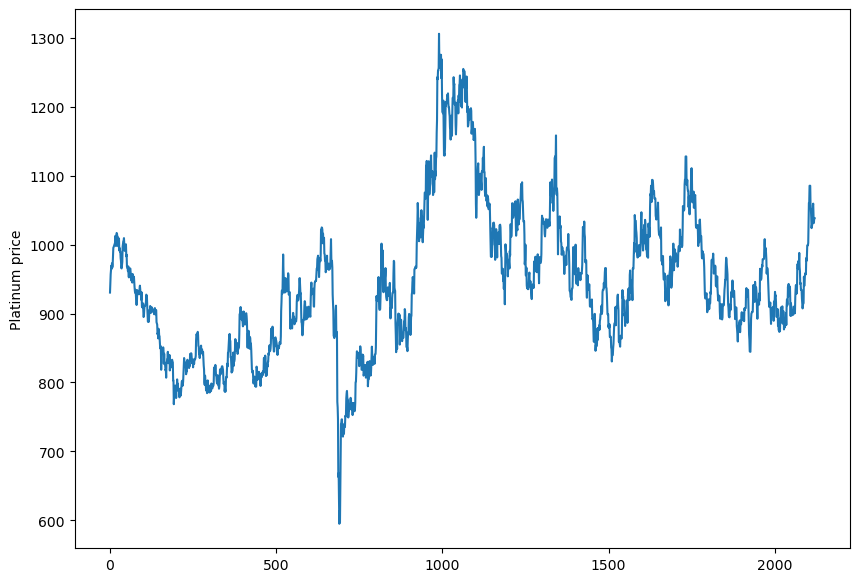

In [7]:
#Đồ thị giá đóng
df.Close.plot(figsize = (10, 7))
plt.ylabel("Platinum price")
plt.show()


In [8]:
#train test split
train_size = int(0.7 * len(df))

train_df = df[:train_size]
test_df = df[train_size:]

In [9]:
model = ETSModel(
    train_df['Close'],
    error="mul",
    trend="add",
    seasonal="mul",
    damped_trend=False,
    seasonal_periods=90)

res = model.fit()
print(res.summary())

                                 ETS Results                                  
Dep. Variable:                  Close   No. Observations:                 1484
Model:                       ETS(MAM)   Log Likelihood               -6010.369
Date:                Thu, 06 Jun 2024   AIC                          12212.738
Time:                        15:04:03   BIC                          12721.778
Sample:                             0   HQIC                         12402.476
                               - 1484   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.025     40.215      0.000       0.951       1.049
smoothing_trend      9.999e-05        nan        nan        nan         nan         nan
smoothing_season

## FORECASTING

In [10]:
predicted = res.predict(start = len(train_df), end = len(train_df) + len(test_df) - 1)

In [11]:
mape = np.mean(np.abs(predicted - test_df['Close'])/np.abs(test_df['Close'])) *100
mse = np.mean(np.square(test_df['Close'] - predicted))
rmse = np.sqrt(mse)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Percentage Error (MAPE): 7.667025882834304
Mean Squared Error (MSE): 8615.62613453974
Root Mean Squared Error (RMSE): 92.82039719016365


In [12]:
# Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Predict the closing prices for the next 90 days
y_next_90_days = res.predict(start = len(df), end = len(df) + 90 - 1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
2121    849.510609
2122    844.223893
2123    844.157241
2124    835.798075
2125    839.474455
           ...    
2206    849.391809
2207    848.672985
2208    845.715325
2209    841.702293
2210    840.737873
Length: 90, dtype: float64


In [13]:
predicted

1484    938.947442
1485    940.858568
1486    937.293281
1487    936.512692
1488    933.261492
           ...    
2116    860.379493
2117    859.652949
2118    856.658596
2119    852.595203
2120    851.619866
Length: 637, dtype: float64

In [14]:
dt_train = np.append(train_df, predicted.iloc[0]) 

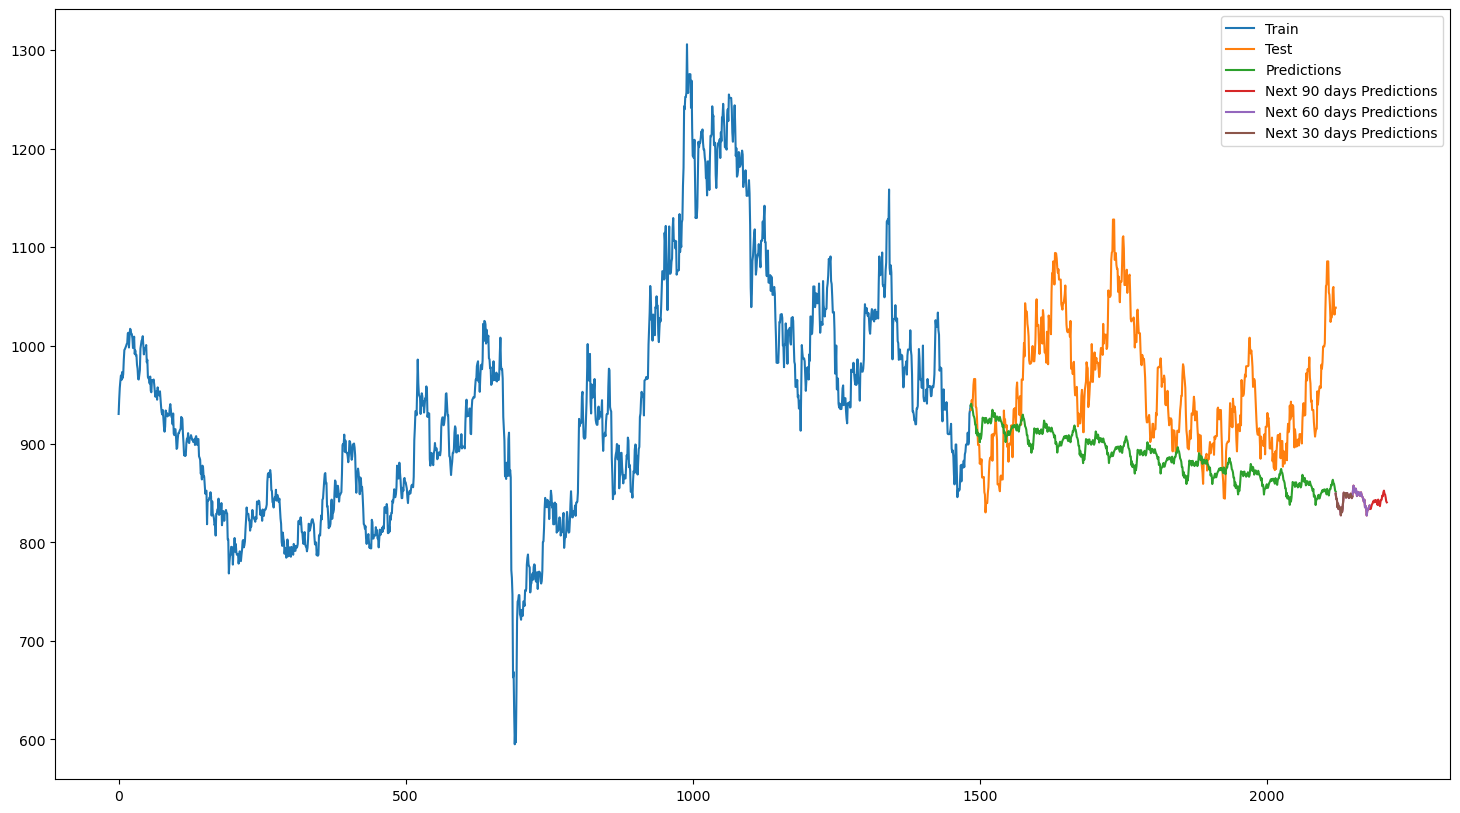

In [15]:
fig, ax = plt.subplots()

plt.plot(pd.RangeIndex(start=0, stop=len(dt_train), step=1), dt_train)
plt.plot(test_df.index, test_df)
plt.plot(test_df.index, predicted)
plt.plot(last_data,y_next_90_days)
plt.plot(pd.RangeIndex(start=last_index, stop=last_index+60, step=1),y_next_90_days[0:60])
plt.plot(pd.RangeIndex(start=last_index, stop=last_index+30, step=1),y_next_90_days[0:30])
plt.legend(['Train', 'Test', 'Predictions', 'Next 90 days Predictions', 'Next 60 days Predictions', 'Next 30 days Predictions'])
plt.show()
